In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import gensim
from gensim.matutils import Sparse2Corpus
from gensim import corpora, models, similarities
from gensim.corpora import Dictionary, MmCorpus
from nltk.corpus import stopwords
import nltk 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re

In [3]:
import time
from dateutil.parser import parse
import requests
import string
from collections import Counter
import datetime, re, sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

In [4]:
job = pd.read_csv('fake_job_postings.csv')

In [5]:
job.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
#check null values
job.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
sns.set_style('whitegrid')

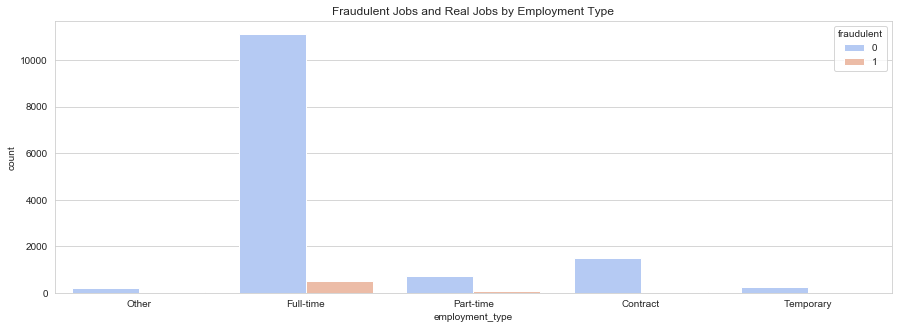

In [8]:
plt.figure(figsize = (15,5))
sns.countplot(data = job, hue = 'fraudulent', x = 'employment_type' , palette = 'coolwarm')
plt.title('Fraudulent Jobs and Real Jobs by Employment Type');

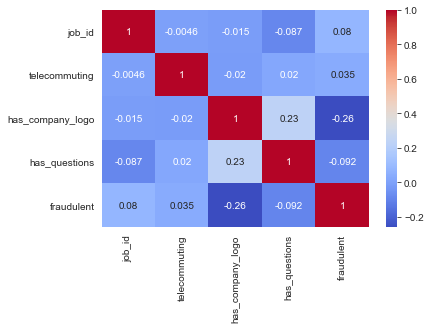

In [9]:
sns.heatmap(job.corr(),cmap='coolwarm',annot=True)

In [10]:
#extract texts columns 
texts = job[["company_profile", "description", "requirements", "fraudulent"]]

In [11]:
texts.fillna(value='and',inplace=True)

D:\anaconda\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [12]:
texts.groupby('fraudulent').describe()

company_profile                   description         \
                     count unique  top  freq       count unique   
fraudulent                                                        
0                    17014   1661  and  2721       17014  14171   
1                      866     50  and   587         866    632   

                                                                    \
                                                          top freq   
fraudulent                                                           
0           Play with kids, get paid for it Love travel? J...  379   
1           We are a full-service marketing and staffing f...   22   

           requirements                    
                  count unique  top  freq  
fraudulent                                 
0                 17014  11495  and  2541  
1                   866    479  and   154

In [13]:
texts['company_profile_len'] = texts['company_profile'].apply(len)
texts['description_len'] = texts['description'].apply(len)
texts['requirement_len'] = texts['requirements'].apply(len)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [14]:
texts.head(2)

,company_profile,description,requirements,fraudulent,company_profile_len,description_len,requirement_len
0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,885,905,852
1,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1286,2077,1433


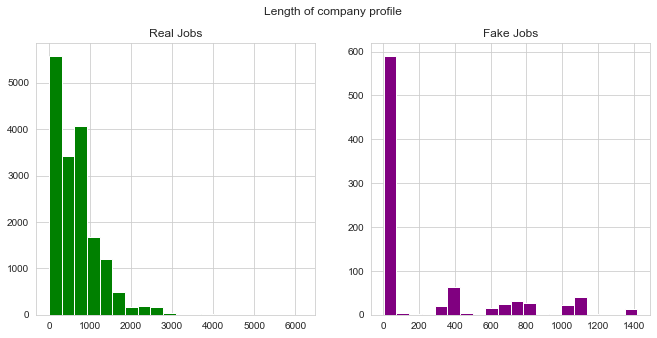

<Figure size 432x288 with 0 Axes>

In [71]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(11, 5))

real = texts[texts["fraudulent"] == 0]['company_profile_len']
ax1.hist(real,bins = 20, color = 'green')
ax1.set_title('Real Jobs')

fake = texts[texts["fraudulent"]==1]['company_profile_len']
ax2.hist(fake, bins = 20, color = 'purple')
ax2.set_title('Fake Jobs')

fig.suptitle('Length of company profile')
plt.show()
plt.tight_layout()

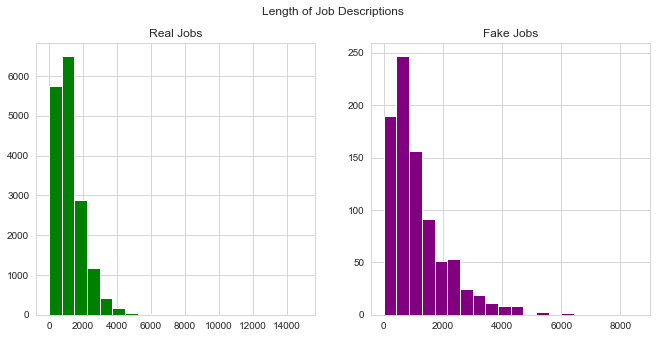

<Figure size 432x288 with 0 Axes>

In [72]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(11, 5))

real = texts[texts["fraudulent"] == 0]['description_len']
ax1.hist(real,bins = 20, color = 'green')
ax1.set_title('Real Jobs')

fake = texts[texts["fraudulent"]==1]['description_len']
ax2.hist(fake, bins = 20, color = 'purple')
ax2.set_title('Fake Jobs')

fig.suptitle('Length of Job Descriptions')
plt.show()
plt.tight_layout()

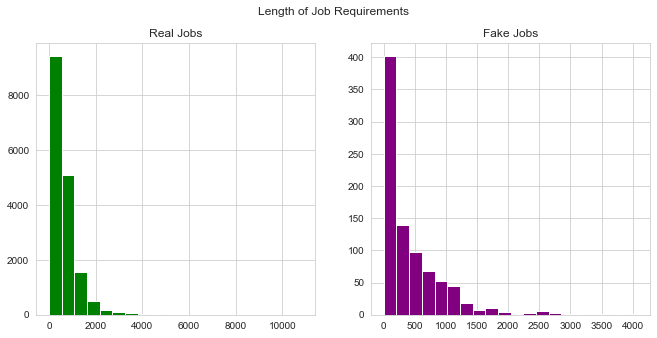

<Figure size 432x288 with 0 Axes>

In [70]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(11, 5))

real = texts[texts["fraudulent"] == 0]['requirement_len']
ax1.hist(real,bins = 20, color = 'green')
ax1.set_title('Real Jobs')

fake = texts[texts["fraudulent"]==1]['requirement_len']
ax2.hist(fake, bins = 20, color = 'purple')
ax2.set_title('Fake Jobs')

fig.suptitle('Length of Job Requirements')
plt.show()
plt.tight_layout()

In [16]:
def token_process(doc):
    
    ## stop words and updates
    ## Note, you should add more terms to this list to see what may or may not be useful.
    ## Also note, that I also remove punctuation here by adding the string module
    stop_en = stopwords.words('english') + list(string.punctuation) + [u'...',u',',u'.',u'?',u'!',u':',u';', u')', u'(',u'[',u']',u'{',u'}',u'%',u'@',u'-',u'`',
                                           u'san',u'francisco',u'san francisco',u'new',u'tr',u'th',u'to',u'on',u'of',u'mr',
                                           u'monday','tuesday',u'wednesday',u'thursday',u'friday',u'saturday',u'sunday','want','befor','becaus'
                                           u'said',u'ms',u'york',u'say',u'could',u'q',u'got',u'found',u'began','|',"''","'s","``","--",
                                           'mr','year','would','one','way','l','ms.','$','mr.','dr.','get','before','like','know','day','because',
                                           '"','see','look','dont','im','&','b','also','de','la','el','en','un','two','al','su','es','lo','se']
    
        
    #stemming
    stemmer = SnowballStemmer("english")
    
    #lemmatizer
    lemmatizer = WordNetLemmatizer() 
    
    #tokenize
    tokens = [w.strip() for sent in sent_tokenize(doc) for w in word_tokenize(sent)] if doc else None
    
    #remove numbers
    num_pat = re.compile(r'^(-|\+)?(\d*).?(\d+)')
    tokens = filter(lambda x: not num_pat.match(x), tokens)
    
    #remove dates
    date_pat =  re.compile(r'^(\d{1,2})(/|-)(\d{1,2})(/|-)(\d{2,4})$')
    tokens = filter(lambda x: not date_pat.match(x), tokens)
    
    #use stemmer
    stemmed_tokens = map(lambda x: stemmer.stem(x), tokens)
    
    #filter out empty tokens and stopwords
    stemmed_tokens = filter(lambda x: x and x.strip() not in stop_en, stemmed_tokens)

    #use lemmatizer
    lemmatized_and_stemmed_tokens = map(lambda x: lemmatizer.lemmatize(x), stemmed_tokens)

    #again filter out empty tokens and stopwords
    lemmatized_and_stemmed_tokens = filter(lambda x: x and x.strip() not in stop_en, lemmatized_and_stemmed_tokens)

    #remove any lingering white space tokens
    lemmatized_and_stemmed_tokens = filter(lambda x: x and x.strip() not in [u' '],lemmatized_and_stemmed_tokens)

    x = ' '.join(lemmatized_and_stemmed_tokens)
    return x.split(' ')

In [17]:
#combine all texts columns into one

cols = ['company_profile', 'description', 'requirements']

texts['combined'] = texts[cols].apply(lambda x: ' '.join(x), axis=1)
texts.drop(cols, axis=1, inplace=True)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
#clean the texts
texts['cleaned'] = texts['combined'].apply(token_process)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
#convert cleaned texts back to str format
texts['cleaned'] = texts['cleaned'].apply(lambda x: " ".join(x))

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
texts.head()

,fraudulent,company_profile_len,description_len,requirement_len,combined,cleaned
0,0,885,905,852,"We're Food52, and we've created a groundbreaki...",food52 creat groundbreak award-win cook site s...
1,0,1286,2077,1433,"90 Seconds, the worlds Cloud Video Production ...",second world cloud video product service.90 se...
2,0,879,355,1363,Valor Services provides Workforce Solutions th...,valor servic provid workforc solut meet need c...
3,0,614,2600,1429,Our passion for improving quality of life thro...,passion improv qualiti life geographi heart ev...
4,0,1628,1520,757,SpotSource Solutions LLC is a Global Human Cap...,spotsourc solut llc global human capit manag c...


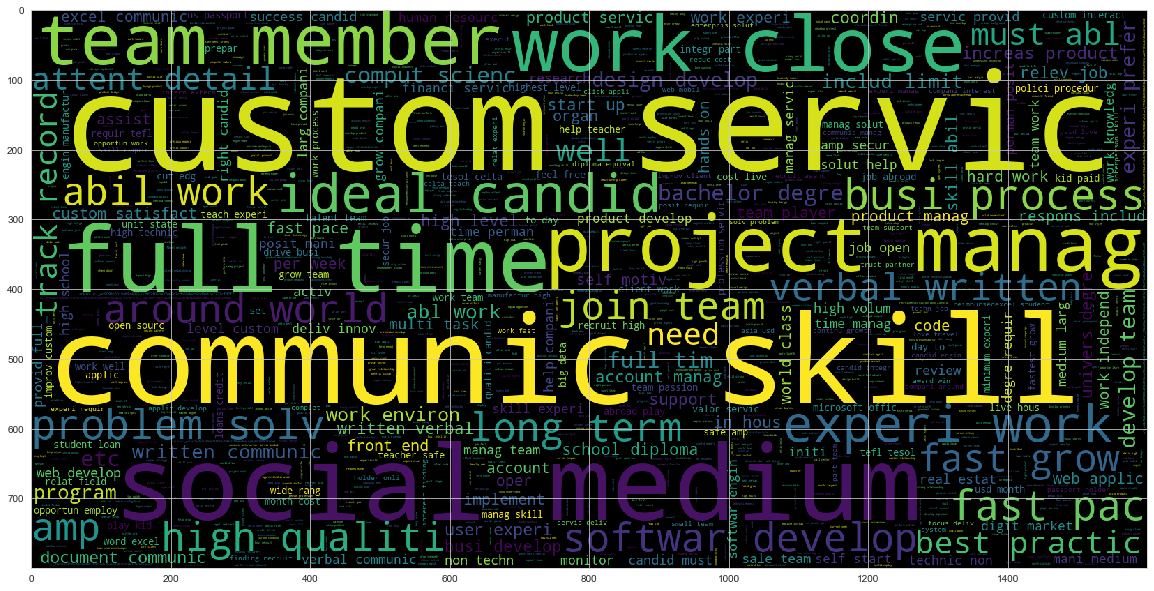

In [22]:
#wordcloud for real job postings
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600, height = 800, max_words = 1000).generate(" ".join (texts[texts.fraudulent == 0].cleaned))
plt.imshow(wc)

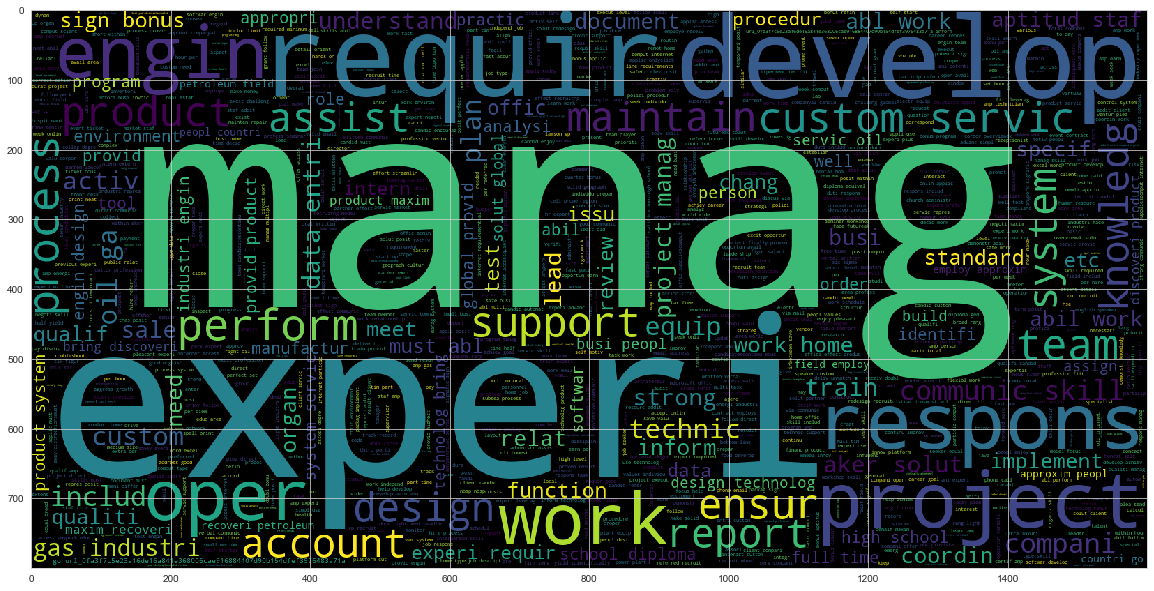

In [23]:
#wordcloud for fake job postings
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600, height = 800, max_words = 1000).generate(" ".join (texts[texts.fraudulent == 1].cleaned))
plt.imshow(wc)

In [27]:
#tfidf analysis for fake postings
tfidf = TfidfVectorizer()

In [28]:
fake = texts[texts['fraudulent'] == 1]

In [29]:
fake.head()

,fraudulent,company_profile_len,description_len,requirement_len,combined,cleaned
98,1,1016,2245,1136,...,staf amp recruit done right oil amp energi ind...
144,1,3,337,3,and The group has raised a fund for the purcha...,group rais fund purchas home southeast student...
173,1,776,4447,1073,Edison International and Refined Resources hav...,edison intern refin resourc partner effort str...
180,1,3,15,15,and Sales Executive Sales Executive,sale execut sale execut
215,1,1016,2246,1137,...,staf amp recruit done right oil amp energi ind...


In [47]:
faketfidf = tfidf.fit_transform(fake['cleaned'])

In [48]:
feature_names = tfidf.get_feature_names()

In [49]:
feature_array = np.array(feature_names)

In [50]:
fakesort = np.argsort(faketfidf.toarray()).flatten()[::-1]

In [51]:
n = 50
top_n_fake = feature_array[fakesort][:n]

In [52]:
#top 50 terms for fake job postings
top_n_fake

array(['marin', 'door', 'schedulegeat', 'liftflexibil', 'mover', 'exp',
       'quantico', 'fundrais', 'concert', 'monet', 'lawyer', 'thier',
       'warren', 'zest', 'anthoni', 'evangel', 'corp', 'brainstorm', 'va',
       'lift', 'ceo', 'earli', 'evolv', 'enlist', 'salesman', 'market',
       'command', 'asap', 'good', 'investor', 'advertis', 'guid', 'estat',
       'affili', 'tour', 'pro', 'idea', 'sell', 'fortun', 'demand',
       'real', 'attitud', 'promot', 'generat', 'small', 'consult', 'find',
       'suppli', 'network', 'effort'], dtype='<U70')

In [61]:
tt = top_n_fake.tolist()

In [65]:
topfake = ",".join(tt)

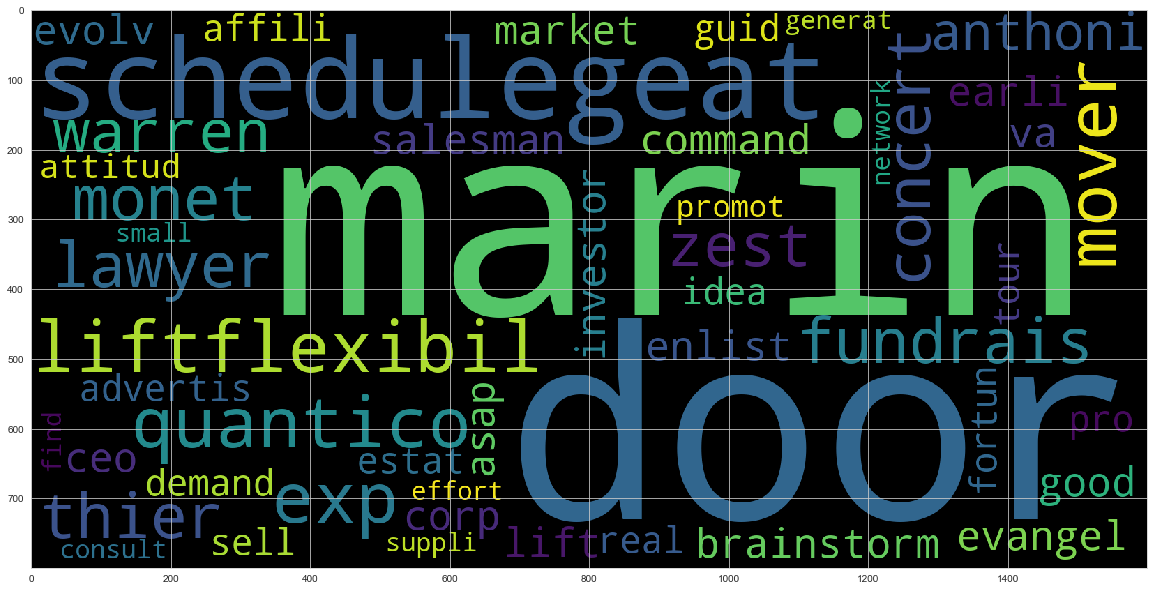

In [73]:
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600, height = 800, max_words = 50).generate(topfake)
plt.imshow(wc)

In [36]:
#machine leanring models

In [37]:
X = texts['combined']
y = texts['fraudulent']

In [38]:
X = tfidf.fit_transform(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state =  101)

KNN model

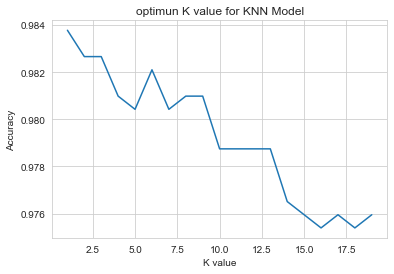

In [40]:
accuracy = []
for k in range(1,20):
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train, y_train)
  accuracy.append(knn.score(X_test, y_test)) 
  
k_list=list(range(1,20)) 
plt.plot(k_list,accuracy)
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('optimun K value for KNN Model')
plt.show()

In [57]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [58]:
print(confusion_matrix(y_test, knn_pred))

[[1694   10]
 [  19   65]]


In [59]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1704
           1       0.87      0.77      0.82        84

    accuracy                           0.98      1788
   macro avg       0.93      0.88      0.90      1788
weighted avg       0.98      0.98      0.98      1788



Random Forest Model

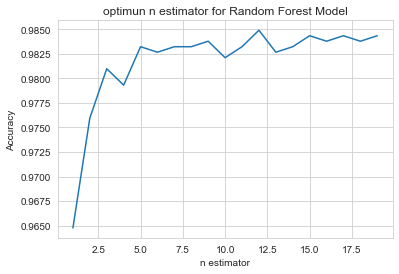

In [53]:
accuracy = []
for i in range(1,20):
  rf = RandomForestClassifier(n_estimators= i) 
  rf.fit(X_train, y_train) 
  accuracy.append(rf.score(X_test,y_test)) 
plt.plot(range(1,20),accuracy) 
plt.xlabel('n estimator')
plt.ylabel('Accuracy')
plt.title('optimun n estimator for Random Forest Model')
plt.show()

In [54]:
rf = RandomForestClassifier(n_estimators= 5)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [55]:
print(confusion_matrix(y_test, rf_pred))

[[1703    1]
 [  33   51]]


In [56]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1704
           1       0.98      0.61      0.75        84

    accuracy                           0.98      1788
   macro avg       0.98      0.80      0.87      1788
weighted avg       0.98      0.98      0.98      1788

